In [1]:
import os
import sys
from tqdm import tqdm
import xarray as xr
import numpy as np
import cv2
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from code_.tools.loading import load_nsd_images, load_image_data
from code_.model_activations.loading import load_full_identifier

from code_.encoding_score.benchmarks.nsd import load_nsd_data, filter_activations
from config import CACHE, FIGURES, NSD_ANNOTS


model_configurations = {'alexnet': 'None', 'expansion':3000}

In [8]:
def perm_pval(test_stat, perm_stats, tail):
    """
    Compute the p-value for a test statistic using permutation statistics.

    Parameters:
    - test_stat: The observed test statistic.
    - perm_stats: An array of permutation test statistics.
    - tail: Specifies the type of test ('left', 'right', or 'both').

    Returns:
    - p_val: The computed p-value.
    """
    x = test_stat
    y = np.array(perm_stats)
    n = y.shape[0] if y.ndim > 1 else len(y)  # Handle 1D arrays as row vectors

    if tail == 'left':
        p_val = (np.sum(y <= x) + 1) / (n + 1)
    elif tail == 'right':
        p_val = (np.sum(y >= x) + 1) / (n + 1)        
    elif tail == 'both':
        x = abs(x)
        y = np.abs(y)
        p_val = (np.sum(y >= x) + 1) / (n + 1)
    else:
        raise ValueError("tail must be 'left', 'right', or 'both'")
    
    print(f"t-statistic: {test_stat}")
    print(f"p-value: {p_val}")
    return



def plot_null_distribution(perm_stats, test_stat, title, file_name, tail='right'):
    """
    Plots a histogram of the null distribution and marks the observed test statistic.

    Parameters:
    - perm_stats: Array of permutation test statistics (null distribution).
    - test_stat: Observed test statistic.
    - tail: Specifies the test type ('left', 'right', or 'both').
    """
    # Create the plot
    plt.figure(figsize=(8, 6))
    sns.histplot(perm_stats, kde=True, bins=30, color="skyblue", label="Null Distribution")
    
    # Plot the test_stat as a vertical line
    plt.axvline(test_stat, color='red', linestyle='--', linewidth=2, label=f'Observed Test Statistic ({test_stat})')
    
    plt.title(title, fontsize=14)
    
    
    plt.xlabel("Test Statistic", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.savefig(os.path.join(FIGURES,file_name))
    plt.show()


def compute_plot_coordinates(image, x, y, image_centers_area_size, offset):
    image_height, image_width, _ = image.shape
    # compute the image center coordinates on the plot
    center_x = int(image_centers_area_size * x) + offset

    # in matplotlib, the y axis is directed upward
    # to have the same here, we need to mirror the y coordinate
    center_y = int(image_centers_area_size * (1 - y)) + offset

    # knowing the image center,
    # compute the coordinates of the top left and bottom right corner
    tl_x = center_x - int(image_width / 2)
    tl_y = center_y - int(image_height / 2)

    br_x = tl_x + image_width
    br_y = tl_y + image_height

    return tl_x, tl_y, br_x, br_y
    

def scale_image(image, max_image_size):
    image_height, image_width, _ = image.shape
    scale = max(1, image_width / max_image_size, image_height / max_image_size)
    image_width = int(image_width / scale)
    image_height = int(image_height / scale)

    image = cv2.resize(image, (image_width, image_height))
    return image


def draw_rectangle_by_class(image, label):
    image_height, image_width, _ = image.shape
    # get the color corresponding to image class
    color = colors_per_class[label]
    image = cv2.rectangle(image, (0, 0), (image_width - 1, image_height - 1), color=color, thickness=5)

    return image

In [9]:
# model and dataset
model_name = 'expansion'
dataset = 'naturalscenes'

# load images seen by subject 1
subject = 1
IDS = load_nsd_data(mode='unshared', subject=subject, region='early visual stream')[0]
images  = [image for image in load_nsd_images() if os.path.basename(image).strip('.png') in IDS]

In [10]:
# load filter activations for images seen by subject 1
identifier = load_full_identifier(model_name=model_name, 
                                  features=model_configurations[model_name], 
                                  layers=5, 
                                  dataset=dataset)
features = xr.open_dataarray(os.path.join(CACHE,'activations',identifier),engine='netcdf4')
features = filter_activations(features, IDS)
tsne_ints = TSNE(n_components=2).fit_transform(features)

In [11]:
ds = xr.open_dataset(NSD_ANNOTS)
IDS_number = [int(i.strip('image')) for i in IDS]
mask = ds.stimulus.stimulus.isin(IDS_number)
ds = ds.sel(stimulus=ds['stimulus'][mask])
df = ds[['count']].to_dataframe().reset_index()
one_hot_df = df.pivot_table(index='stimulus', columns='supercategory', values='count', fill_value=0)
one_hot_df = (one_hot_df > 0).astype(int)  # Convert counts to 1 (presence) and 0 (absence)
category_labels = np.array(one_hot_df.idxmax(axis=1))

In [12]:
# Compute actual difference between within category and between category as well as chance

distances = pdist(tsne_ints, metric='euclidean')
# distances = pdist(images_subset, metric='euclidean')
distance_matrix = squareform(distances)
# Create a mask for within-category distances
within_mask = category_labels[:, None] == category_labels
between_mask = ~within_mask
# Extract distances based on masks
within_distances = distance_matrix[within_mask]
between_distances = distance_matrix[between_mask]
difference = between_distances.mean() - within_distances.mean()


# get chance difference using a permutation test
num_iterations = 100
average_within_cat_dist = np.zeros(num_iterations)
average_between_cat_dist = np.zeros(num_iterations)
for k in tqdm(range(num_iterations)):
    # Shuffle category labels
    shuffled_labels = np.random.permutation(category_labels)
    # Create a mask for within-category and between-category distances
    within_mask = shuffled_labels[:, None] == shuffled_labels
    between_mask = ~within_mask
    # Extract distances based on masks
    within_distances = distance_matrix[within_mask]
    between_distances = distance_matrix[between_mask]
    # Compute and store averages
    average_within_cat_dist[k] = np.mean(within_distances)
    average_between_cat_dist[k] = np.mean(between_distances)
difference_chance = average_between_cat_dist - average_within_cat_dist

100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


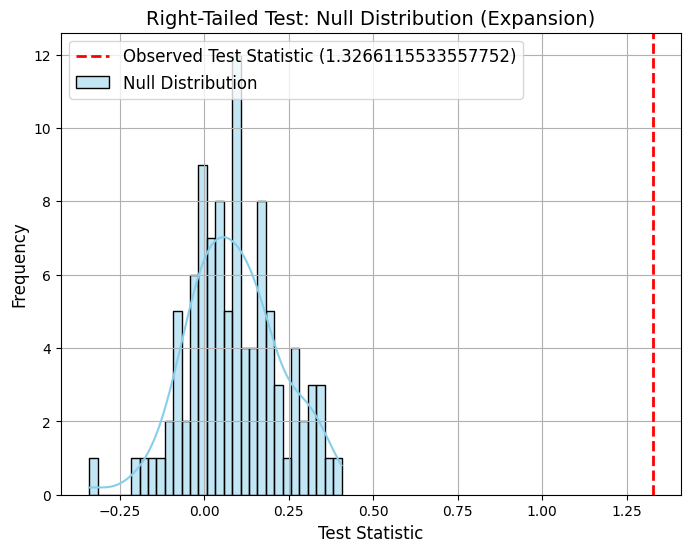

t-statistic: 1.3266115533557752
p-value: 0.009900990099009901


In [13]:
plot_null_distribution(difference_chance, difference,"Right-Tailed Test: Null Distribution (Expansion)", 
                       'null_dist_expansion.png', tail='right')
perm_pval(difference, difference_chance, 'right')

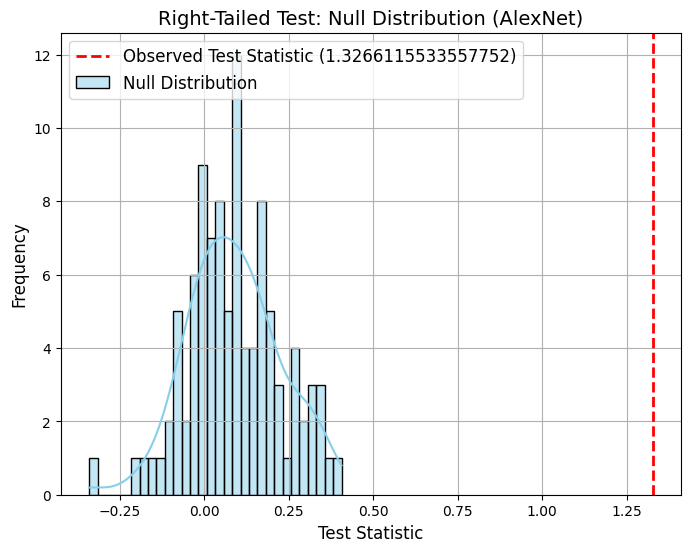

t-statistic: 1.3266115533557752
p-value: 0.009900990099009901


In [14]:
plot_null_distribution(difference_chance, difference,"Right-Tailed Test: Null Distribution (AlexNet)", 
                       'null_dist_alexnet.png', tail='right')
perm_pval(difference, difference_chance, 'right')